In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision import models
from torchvision.datasets.utils import download_url
import pickle as pkl
import random
import os

## Grouping Dataset based on desired attributes

In [6]:
attr = pd.read_csv('data\celeba\list_attr_celeba.csv')
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


<AxesSubplot:xlabel='Blond_Hair', ylabel='count'>

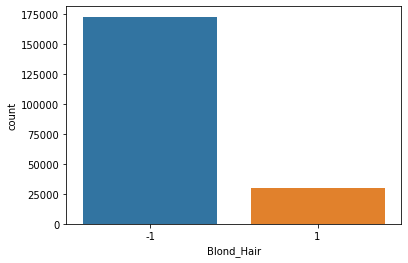

In [13]:
sns.countplot(attr['Blond_Hair'])

C:\Users\Sahil Khan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Black_Hair', ylabel='count'>

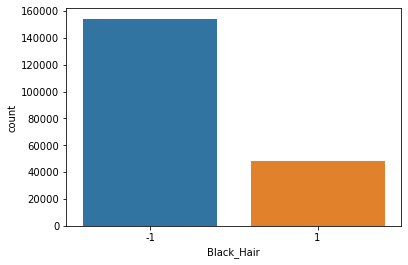

In [14]:
sns.countplot(attr['Black_Hair'])

In [9]:
attr['Male'].unique()

array([-1,  1], dtype=int64)

In [16]:
class FacesDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform):
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)
    

    def __getitem__(self, idx):

        #print("GET!")

        if torch.is_tensor(idx):
            idx = idx.tolist()


        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])

        image = io.imread(img_name)

        sample = image

        sample = Image.fromarray(np.uint8(sample)).convert('RGB')
        

        if self.transform:
            sample = self.transform(sample)

        return sample


male_dataset = FacesDataset(csv_file = 'data\celeba\list_attr_celeba.csv', root_dir= '' , transform= transforms.ToTensor())

landmarks_frame = pd.read_csv('data\celeba\list_attr_celeba.csv')                 # read the csv file with attributes
blond_images_list  = landmarks_frame.iloc[:,20]                    # extract the column with gender attributes
blond_images_list =  blond_images_list[blond_images_list == 1]     # select only the indices for male (attribute val = 1)
blond_images_index = blond_images_list.index       # corresponding image indices

In [17]:
blond_images_index

Int64Index([     0,      1,      8,      9,     11,     12,     13,     16,
                17,     26,
            ...
            202582, 202583, 202586, 202589, 202590, 202591, 202592, 202595,
            202596, 202597],
           dtype='int64', length=92189)

## Regressor

In [ ]:
num_classes = 1
reg1 = models.vgg16(pretrained=True, progress = True, num_classes=num_classes)
Regressor = nn.Sequential([model, nn.Sigmoid])

Regressor = nn.Sequential(
              reg1,
              nn.Sigmoid()
              )

if use_cuda and torch.cuda.is_available():
    Regressor = Regressor.cuda()
    
# dtype = torch.cuda.FloatTensor
# vgg = Vgg16().type(dtype)

## Training Model

In [ ]:
# Training Final Model for Controllable effects

#latent vector size
z_size = 100

#For keeping track
losses = []

#For simplification lets take d vector as only one element
Attr_num = 1
d = np.random.uniform(-1, 1, size=(Attr_num, z_size))
d = torch.from_numpy(d).float()
# move z to GPU if available
if use_cuda and torch.cuda.is_available():
    d = d.cuda()

epsilon = [1]
    
#optimizer
optimizer = optim.Adam(d,lr=0.0002,betas=(0.5,0.999))

L2_loss = nn.MSELoss()
    
def train(E, G, D, n_epochs): #E, G, n_epochs
    
    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        E.cuda()
        G.cuda()
        D.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            x = scale(real_images)

            if use_cuda and torch.cuda.is_available():
                x = x.cuda()
            
            z = E(x)
            z_new = d.t()*epsilon
            x_new = G(z_new)

            loss1 = perceptual_loss(x, x_new)
            loss2 = D(x_new)

            #get the actual attribute of x => α, and using regressor find attribute of x’ => α’
            # loss3 = || α+ ϵ - α’||
            alpha_new = Regressor(x_new)
            alpha = some_funtion(x)
            loss3 = L2_loss(alpha + epsilon - alpha_new)

            loss = loss1 + loss2 + loss3

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #save loss
        losses.append(loss)

        if((epoch+1)%5 == 0):
              save_checkpoint_Fianl(e=epoch)
                
        print('Epoch [{:5d}/{:5d}] | Total_loss: {:6.4f}'.format(
        epoch+1, n_epochs, loss.item()))

    return losses


## Appying Model on any real image

In [ ]:
def Convert(image):
    x = image
    if use_cuda and torch.cuda.is_available():
        x = x.cuda()
    z = E(x)
    z_new = d.t()*epsilon   #epsilon depends which direction you have to go
    x_new = G(z_new)
    return x_new